# Занятие 3:  Нейронные сети 

## Загружаем библиотеки

In [116]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
import math, random
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets, transforms
from torch.nn import functional as F

torch.manual_seed(1)


## Загружаем и анализируем MNIST: датасет для распознавания цифер

In [94]:
# Определим размер "батча"
batch_size = 128

# Загрузим MNIST датасет с помощью torch.utils.data.DataLoader
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=True,  download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])),
            batch_size=batch_size, shuffle=False, drop_last=True)

### Визуализируем данные

torch.Size([128, 1, 28, 28])
tensor(9)


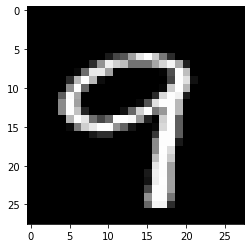

In [95]:
# А заодно и посмотрим как работать с Data Loader

for batch_idx, (minibatch, labels) in enumerate(train_loader):
    
            print(minibatch.shape)

            curr_image = minibatch[0][0]
            curr_label = labels[0]

            print(curr_label)

            plt.imshow(curr_image, cmap='gray')
            
            break

##  Построим нейронную сеть

In [102]:
# Определим модель
model = nn.Sequential(
        nn.Linear(784, 300),
        nn.LeakyReLU(),
        nn.Linear(300, 200),
        nn.Tanh(),
        nn.Linear(200, 10),
        nn.Softmax(),
)

# Определим скорось апдейтом модели
learn_rate = 0.0001 

# Определим способ оптимизации
optimizer = optim.SGD(model.parameters(),lr=learn_rate)

# Определим функцию ошибки
loss_function = nn.CrossEntropyLoss()
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

##  Тренируем нейронную сеть

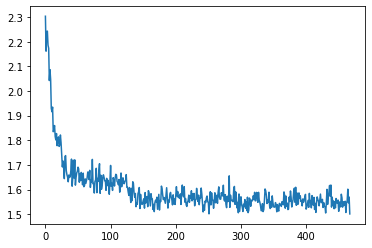

In [103]:
# Определим количество епох
num_ep = 1
    
# Определим очередь (для компактной визуализации)
epochs_tdqm = tqdm(range(num_ep), desc="Loss")

# Будем сохранять ошибки
total_loss = []
 
# собственно цикл тренировки
for epoch in epochs_tdqm:

    #пройдемся по всем батчам из датасета
    for batch_idx, (minibatch, labels) in enumerate(train_loader):
    
        # обединим все пиксели в один вектор
        minibatch = minibatch.reshape(batch_size, 784)
        
        # обнулим градиент
        model.zero_grad()
        
        # forward path: сделаем прогноз
        prediction = model(minibatch)
        
        # backward pass: посчитаем ошибку
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        
        # сохраним ошибку
        epochs_tdqm.set_description("(Loss=%g)" % round(loss.item(), 4))
        total_loss.append(loss.detach().numpy())
        
plt.plot(total_loss)
plt.show()

## Тестируем нейронную сеть

In [44]:
# применяем для классификации на утверждающей выборке
acc_sum = 0

for batch_idx, (minibatch, labels) in enumerate(val_loader):

        minibatch = minibatch.reshape(batch_size, 1, 784)

        labels = labels.reshape(batch_size,1)
        labels = labels.int()        
        
        one_hot_prediction = model(minibatch)

        prediction = np.array( [ [np.argmax(one_hot_prediction[i][0].detach().numpy())] for i in range(batch_size) ] ) 

        acc = sklearn.metrics.accuracy_score(prediction, labels)

        acc_sum =  acc_sum +  acc

print("Average accuracy is: ", acc_sum.item()/ batch_idx )

Average accuracy is:  0.14437905844155843


0  -  0.008062178
1  -  0.008528166
2  -  0.008020906
3  -  0.008085187
4  -  0.007915611
5  -  0.0075276084
6  -  0.00835118
7  -  0.008236236
8  -  0.0070018657
9  -  0.0072813886

 1


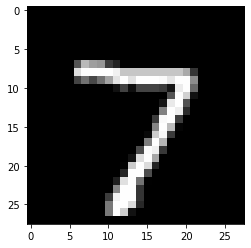

In [45]:
# посмотрим на отдельные примеры
for batch_idx, (image, labels) in enumerate(val_loader):
    
        plt.imshow(image[0][0], cmap='gray')
    
        minibatch = image.reshape(batch_size, 1, 784)

        one_hot_prediction = model(minibatch)
        
        for label in range(10):
            print(label, " - ", one_hot_prediction[0][0][label].detach().numpy())
        
        print("\n", np.argmax(one_hot_prediction[0][0].detach().numpy()))
        
        break

## Сравним с линейной регрессией

In [46]:
learn_rate = 0.0001 

# Определим модель
model = nn.Linear(784, 10)

# Определим способ оптимизации
optimizer = optim.Adam(model.parameters(),lr=learn_rate)

# Определим ошибку
loss_function = nn.CrossEntropyLoss()

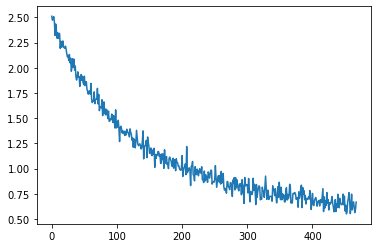

In [47]:
# Определим количество епох
num_ep = 1
    
# Определим очередь (для компактной визуализации)
epochs_tdqm = tqdm(range(num_ep), desc="Loss")

# Будем сохранять ошибки
total_loss = []
 
# собственно цикл тренировки
for epoch in epochs_tdqm:

    #пройдемся по всем батчам из датасета
    for batch_idx, (minibatch, labels) in enumerate(train_loader):
    
        # обединим все пиксели в один вектор
        minibatch = minibatch.reshape(batch_size, 784)
        
        # обнулим градиент
        model.zero_grad()
        
        # forward path: сделаем прогноз
        prediction = model(minibatch)
        
        # backward pass: посчитаем ошибку
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        
        # сохраним ошибку
        epochs_tdqm.set_description("(Loss=%g)" % round(loss.item(), 4))
        total_loss.append(loss.detach().numpy())
        
plt.plot(total_loss)
plt.show()

In [48]:
# применяем регресию для классификации на тестовой выборке
acc_sum = 0

for batch_idx, (minibatch, labels) in enumerate(val_loader):
    
        if minibatch.size(0) != batch_size:
            continue # end of dataset

        minibatch = minibatch.reshape(batch_size, 1, 784)

        labels = labels.reshape(batch_size,1)
        labels = labels.int()
        
        
        
        one_hot_prediction = model(minibatch)

        prediction = np.array( [ [np.argmax(one_hot_prediction[i][0].detach().numpy())] for i in range(batch_size) ] ) 

        acc = sklearn.metrics.accuracy_score(prediction, labels)

        acc_sum =  acc_sum +  acc

print("Average accuracy is: ", acc_sum.item()/ batch_idx )

Average accuracy is:  0.8683035714285714


0  -  -0.968127
1  -  -1.0802978
2  -  -0.2494494
3  -  0.6189412
4  -  0.24147569
5  -  -0.2372607
6  -  -2.1547847
7  -  4.9373083
8  -  -0.6912342
9  -  1.7612119
7


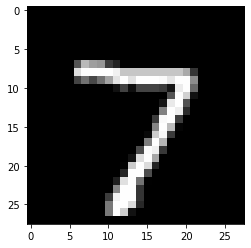

In [49]:
# посмотрим на отдельные примеры
for batch_idx, (image, labels) in enumerate(val_loader):
    
        plt.imshow(image[0][0], cmap='gray')
    
        minibatch = image.reshape(batch_size, 1, 784)

        one_hot_prediction = model(minibatch)
        
        for label in range(10):
            print(label, " - ", one_hot_prediction[0][0][label].detach().numpy())
        
        print(np.argmax(one_hot_prediction[0][0].detach().numpy()))
        
        break

# Перейдем на другой датасет

## Загрузим данные о предсказание смертности от рака

In [104]:
# Загрузим датасет
data_file = "../data/cancer_regr.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')
print(df.columns)
df = df.dropna()


Index(['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate',
       'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc',
       'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'Geography',
       'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24',
       'PctSomeCol18_24', 'PctBachDeg18_24', 'PctHS25_Over',
       'PctBachDeg25_Over', 'PctEmployed16_Over', 'PctUnemployed16_Over',
       'PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage',
       'PctPublicCoverage', 'PctPublicCoverageAlone', 'PctWhite', 'PctBlack',
       'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate',
       'Unnamed: 34'],
      dtype='object')


In [105]:
# Выберем дополнительнуе фичи
df_poverty =  df['povertyPercent']
df_incidence = df['incidenceRate']
df_death_rate = df['TARGET_deathRate']
df_total_death = df['avgDeathsPerYear']
df_med_income = df['medIncome']
df_age = df['MedianAge']
df_unemp = df['PctUnemployed16_Over']

df = pd.concat([df_poverty, df_incidence, df_death_rate, df_total_death, df_med_income, df_age, df_unemp ], axis=1).dropna()

In [106]:
# Как всегда, уберем outlier
z = np.abs(stats.zscore(df))
threshold = 3
df = df[(z < threshold).all(axis=1)]

In [107]:
# Нормализируем данные
def normalize(data_frame):
    mu = data_frame.mean()
    sigma = data_frame.std()
    scaled_data_frame = (data_frame.values-mu)/sigma
    return scaled_data_frame

# Poverty
scaled_poverty = normalize(df['povertyPercent'])

# Incident rate
scaled_incident = normalize(df['incidenceRate'])

# total Death
scaled_t_death = normalize(df['avgDeathsPerYear'])

# Med income
scaled_m_income = normalize(df['medIncome'])

# Average age
scaled_age = normalize(df['MedianAge'])

# Percent unemployed
sclaed_unempl = normalize( df['PctUnemployed16_Over'])

# Death Rate
scaled_death_r = normalize(df['TARGET_deathRate'])


# Определим датасет

x_data = np.array([scaled_poverty,scaled_incident, scaled_t_death, scaled_m_income, scaled_age, sclaed_unempl]).transpose()

y_data = np.expand_dims(scaled_death_r, axis=1)

In [108]:
# check dimensions
print(x_data.shape)
print(y_data.shape)

(549, 6)
(549, 1)


In [109]:
## Разделяем дата на выборки
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=False)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 439.
Data points in val set: 110.
Shape of features in training data: (439, 6)
Shape of output in training data: (439, 1)
Shape of features in val data: (110, 6)
Shape of output in val data: (110, 1)


## Применяем нейронную сеть

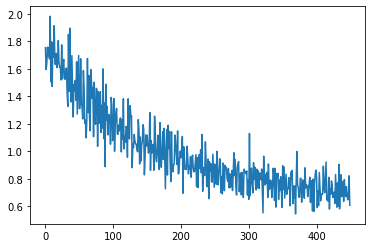

In [126]:
# Определим размер "батча"
batch_size = 128

# Определим датасет
class Dataset(torch.utils.data.Dataset):
  def __init__(self, inp, out):
        self.inp = inp
        self.out = out

  def __len__(self):
        return len(self.inp)

  def __getitem__(self, index):
        # Select sample
        input_ = self.inp[index]
        output_ = self.out[index]

        return input_, output_
    
training_set = Dataset(X_train, y_train)

# Определим Data Loader
training_generator = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=batch_size, drop_last=True)

# Определим скорость апдейта параметров
learning_rate = 1e-3

# Определим модель
model = nn.Sequential(
        nn.Linear(6, 1)
)

# Определим способ оптимизации
optimiz = optim.SGD(model.parameters(), lr=learning_rate)

# Определим ошибку
loss_function = nn.MSELoss()

# ----------               Тренируем сетку          --------------------

# Определим количество епох
num_ep = 150
    
# Определим очередь (для компактной визуализации)
epochs_tdqm = tqdm(range(num_ep), desc="Loss")

# Будем сохранять ошибки
total_loss = []
 
# собственно цикл тренировки
for epoch in epochs_tdqm:

    #пройдемся по всем батчам из датасета
    for minibatch, labels in training_generator:
    
        # обединим все пиксели в один вектор
        # minibatch = minibatch.reshape(batch_size, 784)
        minibatch = minibatch.float()
        
        # обнулим градиент
        model.zero_grad()
        
        # forward path: сделаем прогноз
        prediction = model(minibatch)
        
        # backward pass: посчитаем ошибку
        loss = loss_function(prediction, labels.float())
        loss.backward()
        optimiz.step()
        
        # сохраним ошибку
        epochs_tdqm.set_description("(Loss=%g)" % round(loss.item(), 4))
        total_loss.append(loss.detach().numpy())
        
plt.plot(total_loss)
plt.show()

Coefficient of determination: 0.13


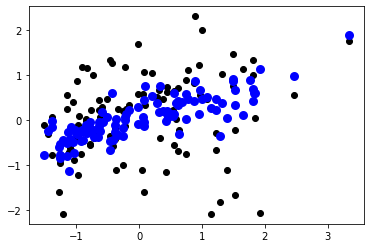

In [130]:
# Определим утверждающую выборку
val_set = Dataset(X_val, y_val)
validation_generator = torch.utils.data.DataLoader(val_set)

X_v = torch.tensor(X_val)

# Применяем на утверждающей выборке
y_pred = model(X_v.float()).detach().numpy()


# Посчитаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, y_pred))


# Визуализируем
plt.scatter(X_val[:,0], y_val,  color='black')
plt.scatter(X_val[:,0], y_pred, color='blue', linewidth=3)


plt.show()

In [131]:
# Применяем на тренировочной выборке
X_t = torch.tensor(X_train)
y_pred = model(X_t.float()).detach().numpy()

# Посчитаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination on the training data: %.2f'
      % r2_score(y_train, y_pred))

Coefficient of determination on the training data: 0.33


## Применяем метод К ближайших соседей в многоразмерном случае

Coefficient of determination: 0.22


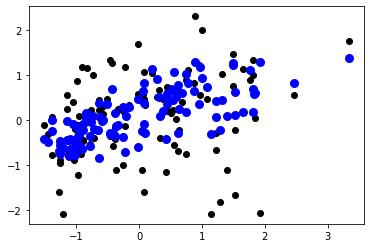

In [132]:
# Потроим "модель"
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
K = 35
knn = KNeighborsRegressor(n_neighbors=K, weights = "distance")
knn.fit(X_train, y_train)

# Применяем
y_pred = knn.predict(X_val)

# Посчитаем Коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, y_pred))

# Визуализируем
plt.scatter(X_val[:,0], y_val,  color='black')
plt.scatter(X_val[:,0], y_pred, color='blue', linewidth=3)


plt.show()

## Сравним с полиномиальной регрессией

Coefficient of determination: 0.30


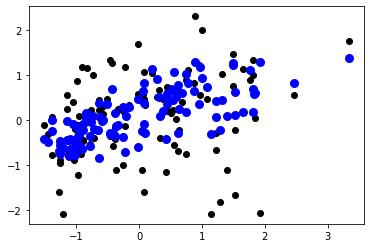

In [133]:
# Построить регрессию
# Задаем степень полинома
polynomial_degree = 1

# Описиваем полиновиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
ploy_load_pred = polyreg.predict(X_val)


# Считаем коэффициент детерминации
# https://en.wikipedia.org/wiki/Coefficient_of_determination
print('Coefficient of determination: %.2f'
      % r2_score(y_val, ploy_load_pred))


# Визуализируем
plt.scatter(X_val[:,0], y_val,  color='black')
plt.scatter(X_val[:,0], y_pred, color='blue', linewidth=3)


plt.show()

# Перейдем к временным рядам

/home/tarask/Documents/LABA_ML_Course/Code/laba_env/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


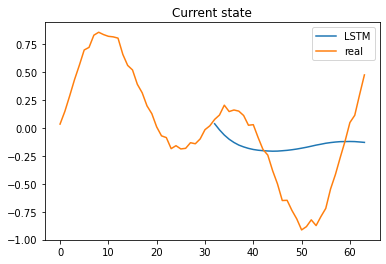

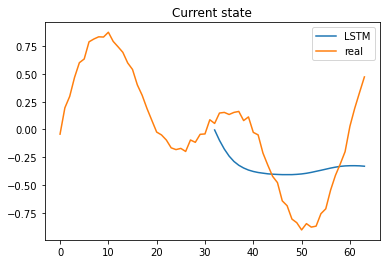

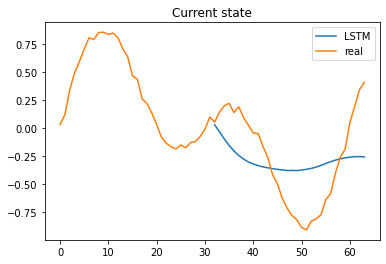

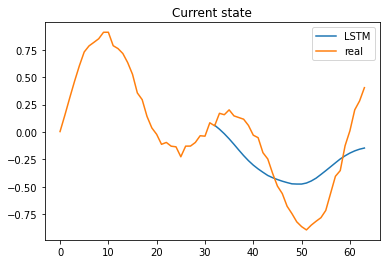

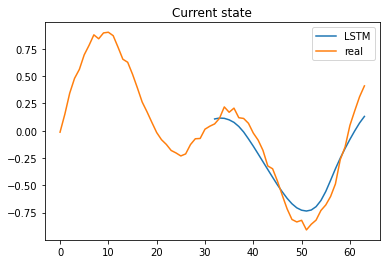

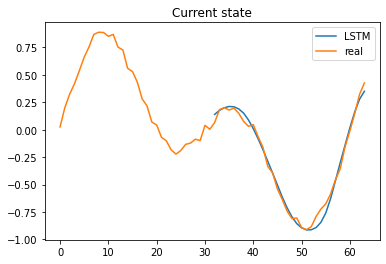

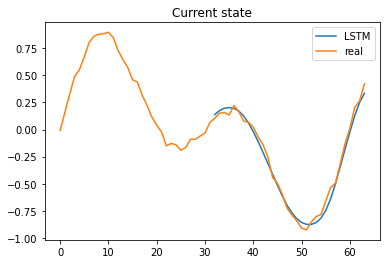

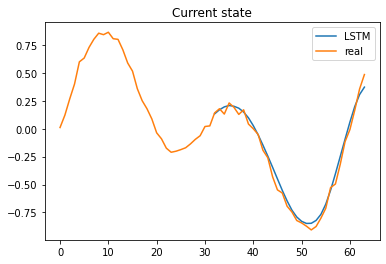

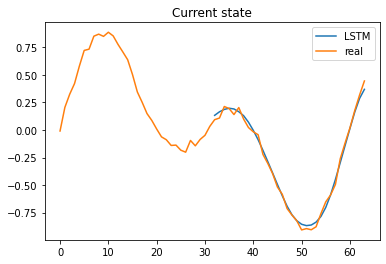

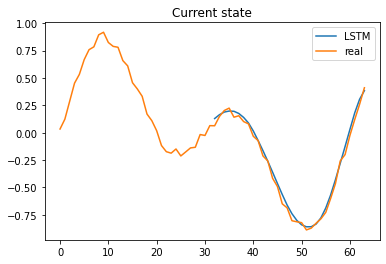

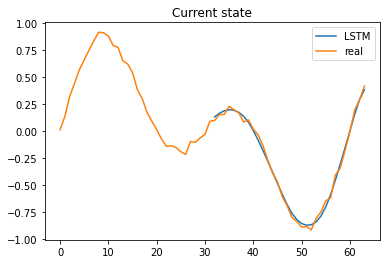

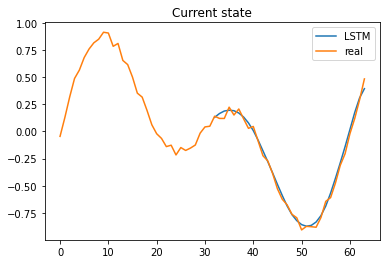

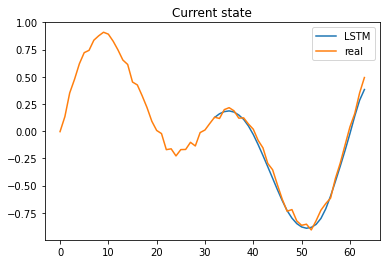

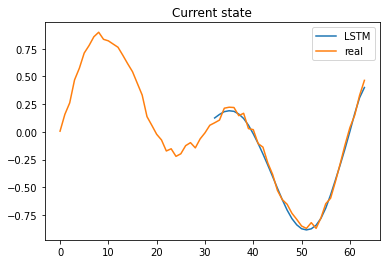

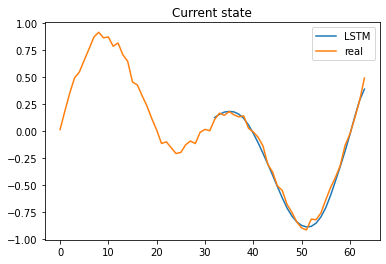

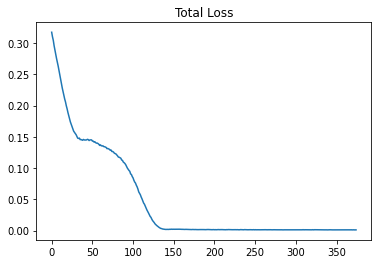

In [134]:
# Определим функцию которые мы будем пытаться апроксимировать

def sine_2(X, signal_freq=60.):
    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine_2(X)) # + random_offset))
    
    return np.array(Y)


# Создадим клас для модели
class LSTM_pred(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_dim):
        super(LSTM_pred, self).__init__()

        self.encod = nn.Linear(1, 10)
        self.lstm = nn.LSTM(input_size=10, hidden_size=10, dropout=0.1, batch_first=True)
        self.decode = nn.Linear(10, 1)


    def forward(self, input_seq):
        
        enc_input = self.encod(input_seq)
        lstm_out, _ = self.lstm(enc_input)
        output = self.decode(lstm_out)
        
        return output
    
# Определим модель
hidden_size = 25
model = LSTM_pred(1,hidden_size,1)
prediction_length = 32

# Определим параметры оптимизации
n_epochs = 15
n_iters = 25
batch_size = 32
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = np.zeros(n_epochs) # For plotting
    
epochs_tdqm = tqdm(range(n_epochs), desc="Loss")

total_loss = []

# тренируем модель
for epoch in epochs_tdqm:

    for iter in range(n_iters):
        
        training_samples = [sample(prediction_length*2) for i in range(batch_size)]
        
        # форматируем
        training_samples = torch.tensor(training_samples).float()
        training_samples = training_samples.view(batch_size, -1,1)
        
        inputs =  training_samples[:, :prediction_length ]
        targets = training_samples[:, prediction_length: ]
        
        outputs = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        epochs_tdqm.set_description("(Loss=%g)" % round(loss.item(), 4))
        total_loss.append(loss.detach().numpy())
      
    x = np.arange(prediction_length, 2*prediction_length)
    plt.plot(x, outputs[0,:,0].detach().numpy())
    plt.plot(training_samples[0,:,0].numpy())
    plt.legend(['LSTM','real'])
    plt.title('Current state')
    plt.show()  
    
        
plt.plot(total_loss)
plt.title('Total Loss')
plt.show()        

Text(0.5, 1.0, 'LSTM')

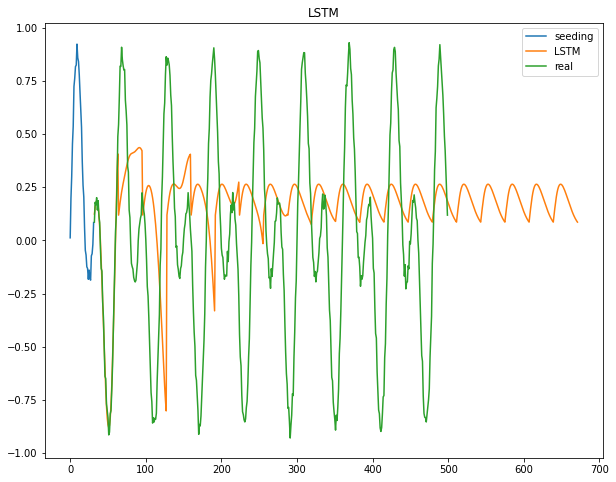

In [135]:
# Протестируем

y = sample(600)

seed  = y[:prediction_length].reshape(1, -1, 1)

curr_seq = torch.tensor(seed).float()

# Итеративно прогнозируем будующее
preds = []
for i in range(20):
    pred = model(curr_seq.float())
    preds.append(pred.data.numpy().ravel())
    curr_seq = pred
       
preds  = np.array(preds)
predic_seq = preds.flatten()


xs = np.arange(1000)

plt.figure(figsize=[10,8])

plt.plot(xs[:prediction_length],seed[0,:,0])

plt.plot(xs[prediction_length:prediction_length*21], predic_seq)

plt.plot(xs[prediction_length:500], y[prediction_length:500])

plt.legend(['seeding','LSTM','real'])
plt.title('LSTM')